In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor

from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
from PIL import Image
import matplotlib.pyplot as plt

### GaitSequenceDataset

In [14]:
class GaitSequenceDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_id=100, sequence_length=3): #change back to 100 or whatever later
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.max_id = max_id
        self.subfolders = ['A1_silhouette', 'A2_silhouette', 'A3_silhouette']
        self.sequence_length = sequence_length
        self.load_dataset()

    def load_dataset(self):
        user_id_folders = sorted(next(os.walk(self.root_dir))[1])[:self.max_id]  # Limit to the first N user ids IDs

        for user_id in user_id_folders:
            for subfolder in self.subfolders:
                silhouette_dir = os.path.join(self.root_dir, user_id, subfolder)
                if os.path.isdir(silhouette_dir):
                    image_files = sorted(os.listdir(silhouette_dir))
                    for i in range(0, len(image_files) - self.sequence_length + 1, self.sequence_length):
                        self.data.append([
                            os.path.join(silhouette_dir, image_files[i + j]) 
                            for j in range(self.sequence_length)
                        ])
                        self.labels.append(int(user_id.lstrip('0')))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_paths = self.data[idx]
        images = [Image.open(image_path) for image_path in image_paths]
        if self.transform:
            images = [self.transform(img) for img in images]
        stacked_images = torch.cat(images, dim=0)  # Shape: [3, 128, 128]
        label = self.labels[idx] - 1  # Adjust labels to be 0-indexed
        return stacked_images, label

# Generate Different Dataset Configurations
Remark: This is done in order to test the behavior of different model architecture

##### Num user_id = 100 users, image sequence = 5 images

In [15]:
MAX_ID = 100
SEQUENCE_LENGTH = 3

transform = Compose([ToTensor()])
root_dir = r'C:\Users\Win\Desktop\GaitCO\processed_images\00001-04000'
dataset = GaitSequenceDataset(
    root_dir=root_dir, 
    transform=transform, 
    max_id=MAX_ID, 
    sequence_length=SEQUENCE_LENGTH,
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

### BigCNN.py

In [16]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes, num_img_sequence):
        super(CNNClassifier, self).__init__()
        # We will now treat the sequence of images as a single input with multiple channels
        self.conv1 = nn.Conv2d(num_img_sequence, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Removed softmax here for numerical stability with nn.CrossEntropyLoss
        return x


# Assume that 'num_classes' is the total number of classes you have
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BIGCNN_num_classes = MAX_ID
BIGCNN_num_img_sequence = SEQUENCE_LENGTH

model = CNNClassifier(num_classes=BIGCNN_num_classes, num_img_sequence=SEQUENCE_LENGTH).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epoch_losses = []
epoch_accuracies = []

# Training loop
print('Start Training Simple CNN')
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = (correct_predictions / total_predictions) * 100

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(accuracy)
    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}%')

# Testing loop
model.eval()  # Set the model to evaluation mode
y_true = []
y_pred = []
with torch.no_grad():  # No need to track the gradients
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(f'{i}: y: {labels} --> y_pred: {predicted}')
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# Calculate metrics using true labels and predictions
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Testing Metrics: Accuracy: {accuracy*100:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Using device: cuda
Start Training Simple CNN
Epoch 1/10, Loss: 3.1415373243715505, Accuracy: 28.422644045019318%
Epoch 2/10, Loss: 0.4884090261220184, Accuracy: 86.62859062657483%
Epoch 3/10, Loss: 0.15736221311508086, Accuracy: 95.4980682009071%
Epoch 4/10, Loss: 0.1129176419831187, Accuracy: 96.77473542751554%
Epoch 5/10, Loss: 0.07569050710799732, Accuracy: 97.6818410885268%
Epoch 6/10, Loss: 0.07930758372936471, Accuracy: 97.84982361834369%
Epoch 7/10, Loss: 0.05029717462777947, Accuracy: 98.57214849655635%
Epoch 8/10, Loss: 0.04481008857853939, Accuracy: 98.75692927935495%
Epoch 9/10, Loss: 0.041118481183701414, Accuracy: 98.8241222912817%
Epoch 10/10, Loss: 0.04051622208670071, Accuracy: 98.97530656811692%
0: y: tensor([40, 77, 54, 41], device='cuda:0') --> y_pred: tensor([40, 77, 54, 41], device='cuda:0')
1: y: tensor([87, 82, 74, 79], device='cuda:0') --> y_pred: tensor([87, 82, 74, 79], device='cuda:0')
2: y: tensor([15, 65, 82, 39], device='cuda:0') --> y_pred: tensor([15, 65

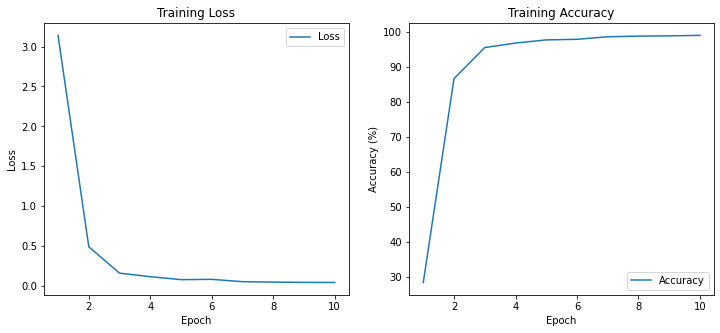

In [17]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), epoch_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), epoch_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [18]:
# print("Saving Model State - BigCNN")
# save_path = "C:/Users/Win/Desktop/GaitCO/CNN_Models/BigCNN-100-3.pth"
# torch.save(model.state_dict(), save_path)

### FourSplitCNN

In [19]:
class FourSplitCNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FourSplitCNNClassifier, self).__init__()

        # Separate convolution layers for each strip
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.conv1_2 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.conv1_3 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2_3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.conv1_4 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2_4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Adjust the input size for fc1
        self.fc1 = nn.Linear(64 * 4 * 8 * 32, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        batch_size = x.size(0)
        strips = torch.chunk(x, 4, dim=2)
        
        # Process each strip independently
        processed_strips = []
        for i, strip in enumerate(strips):
            strip = strip.squeeze(dim=1)  # Adjust dimension for conv1
            if i == 0:
                out = self.maxpool(self.relu(self.conv1_1(strip)))
                out = self.maxpool(self.relu(self.conv2_1(out)))
            elif i == 1:
                out = self.maxpool(self.relu(self.conv1_2(strip)))
                out = self.maxpool(self.relu(self.conv2_2(out)))
            elif i == 2:
                out = self.maxpool(self.relu(self.conv1_3(strip)))
                out = self.maxpool(self.relu(self.conv2_3(out)))
            else:
                out = self.maxpool(self.relu(self.conv1_4(strip)))
                out = self.maxpool(self.relu(self.conv2_4(out)))

            processed_strips.append(out)

        # Concatenate the processed strips
        concatenated = torch.cat(processed_strips, dim=1)
        concatenated = torch.flatten(concatenated, start_dim=1)

        x = self.relu(self.fc1(concatenated))
        x = self.fc2(x)
        return x


model = FourSplitCNNClassifier(num_classes=MAX_ID).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epoch_losses = []
epoch_accuracies = []

# Training loop
print('Start Training FourSplitCNN')
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = (correct_predictions / total_predictions) * 100

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(accuracy)
    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}%')

# Testing loop
model.eval()  # Set the model to evaluation mode
y_true = []
y_pred = []
with torch.no_grad():  # No need to track the gradients
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(f'{i}: y: {labels} --> y_pred: {predicted}')
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# Calculate metrics using true labels and predictions
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Testing Metrics: Accuracy: {accuracy*100:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Start Training FourSplitCNN
Epoch 1/10, Loss: 4.059121253908361, Accuracy: 10.364522089702671%
Epoch 2/10, Loss: 1.3140818780879793, Accuracy: 64.74046699143288%
Epoch 3/10, Loss: 0.3780391303486365, Accuracy: 89.63547791029734%
Epoch 4/10, Loss: 0.16446477252223182, Accuracy: 95.76684024861414%
Epoch 5/10, Loss: 0.10674303300762132, Accuracy: 97.345876028893%
Epoch 6/10, Loss: 0.06790886121068979, Accuracy: 98.25298168990425%
Epoch 7/10, Loss: 0.0719899517608629, Accuracy: 97.74903410045356%
Epoch 8/10, Loss: 0.04526475175295396, Accuracy: 98.68973626742819%
Epoch 9/10, Loss: 0.06047533379751181, Accuracy: 98.26977994288593%
Epoch 10/10, Loss: 0.047963002231179115, Accuracy: 98.57214849655635%
0: y: tensor([40, 77, 54, 41], device='cuda:0') --> y_pred: tensor([40, 77, 54, 41], device='cuda:0')
1: y: tensor([87, 82, 74, 79], device='cuda:0') --> y_pred: tensor([87, 82, 74, 79], device='cuda:0')
2: y: tensor([15, 65, 82, 39], device='cuda:0') --> y_pred: tensor([15, 65, 82, 39], device=

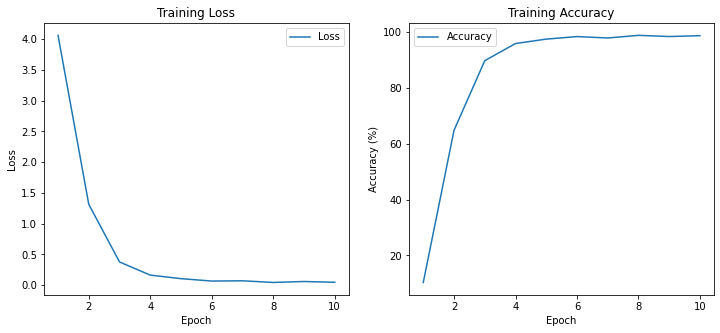

In [20]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), epoch_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), epoch_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [21]:
# print("Saving Model State - FourSplitCNN")
# save_path = "C:/Users/Win/Desktop/GaitCO/CNN_Models/FourSplitCNN-100-3.pth"
# torch.save(model.state_dict(), save_path)

### TransformerCNN

In [22]:
class CNNTransformerClassifier(nn.Module):
    def __init__(self, num_classes, d_model=512, nhead=8, num_transformer_layers=3):
        super(CNNTransformerClassifier, self).__init__()
        
        self.d_model = d_model

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Flattening layer
        self.flatten = nn.Flatten()

        # Linear layer to transform the feature dimension
        self.feature_transform = nn.Linear(64 * 32 * 32, d_model)

        # Transformer encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_transformer_layers)

        # Fully connected layer for classification
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))

        # Flatten and transform the feature dimension
        x = self.flatten(x)
        x = self.feature_transform(x)

        # Reshape for transformer encoder: [batch size, sequence length, features]
        x = x.view(x.size(0), -1, self.d_model)

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Classification head
        x = self.fc(x[:, 0, :])  # Use the output corresponding to the first token
        return x

model = CNNTransformerClassifier(num_classes=MAX_ID).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epoch_losses = []
epoch_accuracies = []

# Training loop
print('Start Training TransformerCNN')
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = (correct_predictions / total_predictions) * 100

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(accuracy)
    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}%')

# Testing loop
model.eval()  # Set the model to evaluation mode
y_true = []
y_pred = []
with torch.no_grad():  # No need to track the gradients
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(f'{i}: y: {labels} --> y_pred: {predicted}')
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# Calculate metrics using true labels and predictions
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Testing Metrics: Accuracy: {accuracy*100:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Start Training TransformerCNN
Epoch 1/10, Loss: 4.32849641039197, Accuracy: 6.584915168822443%
Epoch 2/10, Loss: 1.0935057051194603, Accuracy: 74.41626070888627%
Epoch 3/10, Loss: 0.18308682615016234, Accuracy: 96.57315639173525%
Epoch 4/10, Loss: 0.10858493535219622, Accuracy: 97.73223584747186%
Epoch 5/10, Loss: 0.0830013860039969, Accuracy: 98.03460440114227%
Epoch 6/10, Loss: 0.08056555714033221, Accuracy: 98.26977994288593%
Epoch 7/10, Loss: 0.08432201018551166, Accuracy: 97.84982361834369%
Epoch 8/10, Loss: 0.058111908111792114, Accuracy: 98.55535024357467%
Epoch 9/10, Loss: 0.03580928418933374, Accuracy: 99.04249958004368%
Epoch 10/10, Loss: 0.06585289268892162, Accuracy: 98.05140265412398%
0: y: tensor([40, 77, 54, 41], device='cuda:0') --> y_pred: tensor([40, 77, 54, 41], device='cuda:0')
1: y: tensor([87, 82, 74, 79], device='cuda:0') --> y_pred: tensor([87, 82, 74, 79], device='cuda:0')
2: y: tensor([15, 65, 82, 39], device='cuda:0') --> y_pred: tensor([15, 65, 82, 39], devi

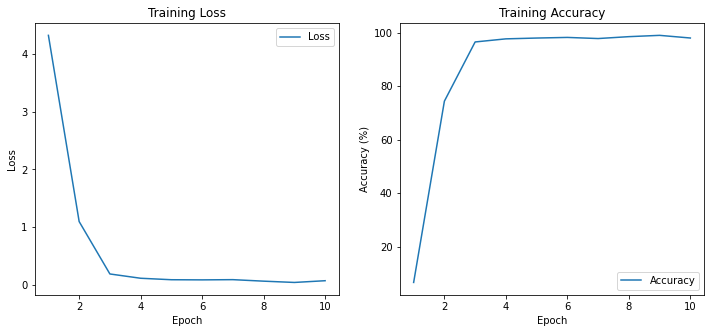

In [23]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), epoch_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), epoch_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [24]:
# print("Saving Model State - TransformerCNN")
# save_path = "C:/Users/Win/Desktop/GaitCO/CNN_Models/TransformerCNN-100-3.pth"
# torch.save(model.state_dict(), save_path)